In [14]:
import os
import numpy as np
import pandas as pd
import math
import glob
import statistics as stat
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import stats
from scipy.stats import variation
from scipy.stats import wilcoxon
from scipy.stats import pearsonr
import warnings
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns
import pingouin as pg
import itertools as it
from great_tables import GT, html
# warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.filterwarnings('ignore')

import typingmod as typ

In [15]:
# Setting save directory
save_dir = r'/Users/rubi/Desktop/Github/typingexp/typing_task_analysis/'\
           'figures/'

In [16]:
def GABA_ID_filter(df):
    filtered = df[df.sID.isin(GABA_sIDs)]
    filtered = filtered.sort_values(by='sID', ascending=True).reset_index(drop=True)
    return filtered

In [17]:
## importing GABA quanitification .csv
## data table is edited to exclude certain data point prior to import
GABA_quant = pd.read_csv(r'/Volumes/greenhouse/MRS/data/Typ_GABA_quant_filtered.csv')
GABA_quant_nofilt = pd.read_csv(r'/Volumes/greenhouse/MRS/data/Typ_GABA_quant.csv')
GABA_sIDs = GABA_quant.sID.unique() ## making list of sIDs with GABA data
df_dir = r'/Users/rubi/Desktop/Github/typingexp/typing_task_analysis/'\
           'dataframes/'

# Importing behavioral metric dataframes. 
file_list = ['iki_metrics_bybf',
            'iki_metrics_bywf',
            'delta_ikis_bybf',
            'delta_ikis_bywf',
            'rts_bywf',
            'delta_rts_bywf',
            'delta_vars_bybf',
            'delta_vars_bywf'
            ]

dfs = {}
for file in file_list: 
    df = pd.read_csv(df_dir + file + '.csv', index_col=0)
    df_filtered = GABA_ID_filter(df)
    filename = os.path.basename(file) # Get the filename
    dfs[filename] = df_filtered

In [18]:
# Function that filters task metric dataframe to only include subjects that have 
# usable data for a given voxel
def pearson_filter(df, bf_or_wf, freq_type, metric, sIDs):
    filtered = df[df[bf_or_wf] == freq_type]
    filtered_2 = filtered[filtered.sID.isin(sIDs)]
    return filtered_2[['sID', metric]]

# Function that runs pearson correlation between a given task metric and voxel
def pearson_corr(df, bf_or_wf, freq_type, metric, voxel):
    sIDs = GABA_quant[(GABA_quant['voxel'] == voxel) & 
                      (GABA_quant['Mean_GABA_Cr'].isna() == False)].sID.unique()
    task_data = pearson_filter(df,
                               bf_or_wf,
                               freq_type,
                               metric,
                               sIDs)
    mrs_data = GABA_quant[GABA_quant['voxel'] == voxel][['sID', 'Mean_GABA_Cr']].dropna()
    print(metric + " " + bf_or_wf + " " + freq_type + " " + 'vs.' +
          " " + voxel + " " + 'GABA')
    print(pearsonr(task_data[metric], mrs_data['Mean_GABA_Cr']))

# Function that outputs the filtered task and MRS data being compared for 
# figure generation.
def task_vs_mrs_plot(df, bf_or_wf, freq_type, metric, voxel):
    sIDs = GABA_quant[(GABA_quant['voxel'] == voxel) & 
                      (GABA_quant['Mean_GABA_Cr'].isna() == False)].sID.unique()
    task_data = pearson_filter(df,
                               bf_or_wf,
                               freq_type,
                               metric,
                               sIDs)
    mrs_data = GABA_quant[GABA_quant['voxel'] == voxel]['Mean_GABA_Cr'].dropna()
    return task_data, mrs_data

# SfN Correlations

## Voxel comparisons

In [69]:
# Comparing R vs. L in the same brain region with ANOVA
regions = ['thal', 'M1', 'occ']

for r in regions:
    if r != 'occ':
        within_region = GABA_quant[GABA_quant['voxel'].str.contains(r)]
    else:
        continue
    # print(f'R_{r} vs. L_{r}')
    # ttest = pg.ttest(within_region, rep10_meaniki, paired=True)
    # print(anova)
    # if anova['p-unc'][0] < 0.05:
    #     print(pg.pairwise_tests(within_region, 'Mean_GABA_Cr', 'voxel', effsize='cohen', padjust='bonf'))

In [70]:
no_occ = GABA_quant[GABA_quant['voxel'] != 'occ']
print(pg.rm_anova(no_occ, dv='Mean_GABA_Cr', within='voxel', subject='sID', correction=True))
pg.pairwise_tests(no_occ, 'Mean_GABA_Cr', 'voxel', effsize='cohen', padjust='bonf')

  Source  ddof1  ddof2         F     p-unc  p-GG-corr       ng2       eps  \
0  voxel      3     57  1.804344  0.156654   0.179679  0.067995  0.646833   

   sphericity  W-spher  p-spher  
0        True      inf      1.0  


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
0,voxel,L_M1,L_thal,False,True,0.890612,26.233935,two-sided,0.381233,1.000000,bonf,0.407,0.279062
1,voxel,L_M1,R_M1,False,True,-1.403236,46.000000,two-sided,0.167261,1.000000,bonf,0.638,-0.405079
2,voxel,L_M1,R_thal,False,True,1.252623,27.631394,two-sided,0.220841,1.000000,bonf,0.559,0.399720
3,voxel,L_thal,R_M1,False,True,-1.634286,27.229970,two-sided,0.113709,0.682254,bonf,0.857,-0.510610
4,voxel,L_thal,R_thal,False,True,0.144002,37.946564,two-sided,0.886261,1.000000,bonf,0.308,0.044750
5,voxel,R_M1,R_thal,False,True,2.116840,28.949416,two-sided,0.042989,0.257934,bonf,1.73,0.672040


# Thalamus Correlations

In [20]:
# Bigram freq. task metrics vs. R and L Thalamic GABA/Cr

pearson_corr(dfs['iki_metrics_bybf'], 
                           'bf_type', 
                           'high', 
                           'mean_IKI',
                           'R_thal')

pearson_corr(dfs['iki_metrics_bybf'], 
                           'bf_type', 
                           'high', 
                           'mean_IKI',
                           'L_thal')

pearson_corr(dfs['iki_metrics_bybf'], 
                           'bf_type', 
                           'high', 
                           'sd_IKI',
                           'R_thal')

pearson_corr(dfs['iki_metrics_bybf'], 
                           'bf_type', 
                           'high', 
                           'sd_IKI',
                           'L_thal')

pearson_corr(dfs['iki_metrics_bybf'], 
                           'bf_type', 
                           'high', 
                           'cv_IKI',
                           'R_thal')

pearson_corr(dfs['iki_metrics_bybf'], 
                           'bf_type', 
                           'high', 
                           'cv_IKI',
                           'L_thal')

pearson_corr(dfs['delta_ikis_bybf'], 
                           'bf_type', 
                           'high', 
                           'mean_deltaiki',
                           'R_thal')

pearson_corr(dfs['delta_ikis_bybf'], 
                           'bf_type', 
                           'high', 
                           'mean_deltaiki',
                           'L_thal')

mean_IKI bf_type high vs. R_thal GABA
PearsonRResult(statistic=np.float64(0.0802827630134081), pvalue=np.float64(0.7365232149374721))
mean_IKI bf_type high vs. L_thal GABA
PearsonRResult(statistic=np.float64(-0.003402492973442602), pvalue=np.float64(0.9883214726514475))
sd_IKI bf_type high vs. R_thal GABA
PearsonRResult(statistic=np.float64(0.10659123912730947), pvalue=np.float64(0.6546767238809053))
sd_IKI bf_type high vs. L_thal GABA
PearsonRResult(statistic=np.float64(0.2068194035242092), pvalue=np.float64(0.3683802193341113))
cv_IKI bf_type high vs. R_thal GABA
PearsonRResult(statistic=np.float64(0.1563966043087256), pvalue=np.float64(0.5102412807703218))
cv_IKI bf_type high vs. L_thal GABA
PearsonRResult(statistic=np.float64(0.33966371662193523), pvalue=np.float64(0.13195784026615542))
mean_deltaiki bf_type high vs. R_thal GABA
PearsonRResult(statistic=np.float64(-0.06106102209276477), pvalue=np.float64(0.7981605852563496))
mean_deltaiki bf_type high vs. L_thal GABA
PearsonRResult

In [21]:
def delta_var_corr(df, voxel, sd_or_cv):
    mrs = GABA_quant[(GABA_quant['voxel'] == voxel) & 
                     (GABA_quant['Mean_GABA_Cr'].isna() == False)]
    sIDs = mrs.sID.unique()
    delta_vars = df[df['sID'].isin(sIDs)].reset_index(drop=True)
    print(pearsonr(delta_vars[sd_or_cv], mrs['Mean_GABA_Cr']))

delta_var_corr(dfs['delta_vars_bybf'], 'R_thal', 'sd_diff')
delta_var_corr(dfs['delta_vars_bybf'], 'L_thal', 'sd_diff')

delta_var_corr(dfs['delta_vars_bybf'], 'R_thal', 'cv_diff')
delta_var_corr(dfs['delta_vars_bybf'], 'L_thal', 'cv_diff')

PearsonRResult(statistic=np.float64(0.1163360586165003), pvalue=np.float64(0.6252418548704775))
PearsonRResult(statistic=np.float64(-0.057237266198623196), pvalue=np.float64(0.8053458184101858))
PearsonRResult(statistic=np.float64(0.20339735959944483), pvalue=np.float64(0.3897374260904811))
PearsonRResult(statistic=np.float64(0.19578853108394323), pvalue=np.float64(0.39501771443195755))


In [22]:
# Word freq. task metrics vs. R and L Thalamic GABA/Cr

pearson_corr(dfs['iki_metrics_bywf'], 
                           'wf_type', 
                           'high', 
                           'mean_IKI',
                           'R_thal')

pearson_corr(dfs['iki_metrics_bywf'], 
                           'wf_type', 
                           'high', 
                           'mean_IKI',
                           'L_thal')

pearson_corr(dfs['iki_metrics_bywf'], 
                           'wf_type', 
                           'high', 
                           'sd_IKI',
                           'R_thal')

pearson_corr(dfs['iki_metrics_bywf'], 
                           'wf_type', 
                           'high', 
                           'sd_IKI',
                           'L_thal')

pearson_corr(dfs['iki_metrics_bywf'], 
                           'wf_type', 
                           'high', 
                           'cv_IKI',
                           'R_thal')

pearson_corr(dfs['iki_metrics_bywf'], 
                           'wf_type', 
                           'high', 
                           'cv_IKI',
                           'L_thal')

pearson_corr(dfs['delta_ikis_bywf'], 
                           'wf_type', 
                           'high', 
                           'mean_deltaiki',
                           'R_thal')

pearson_corr(dfs['delta_ikis_bywf'], 
                           'wf_type', 
                           'high', 
                           'mean_deltaiki',
                           'L_thal')


delta_var_corr(dfs['delta_vars_bywf'], 'R_thal', 'sd_diff')
delta_var_corr(dfs['delta_vars_bywf'], 'L_thal', 'sd_diff')

delta_var_corr(dfs['delta_vars_bywf'], 'R_thal', 'cv_diff')
delta_var_corr(dfs['delta_vars_bywf'], 'L_thal', 'cv_diff')

mean_IKI wf_type high vs. R_thal GABA
PearsonRResult(statistic=np.float64(0.12230359871997666), pvalue=np.float64(0.6074789551566506))
mean_IKI wf_type high vs. L_thal GABA
PearsonRResult(statistic=np.float64(-0.04304288370722724), pvalue=np.float64(0.8530294786575976))
sd_IKI wf_type high vs. R_thal GABA
PearsonRResult(statistic=np.float64(-0.032352735152660926), pvalue=np.float64(0.8922921613489931))
sd_IKI wf_type high vs. L_thal GABA
PearsonRResult(statistic=np.float64(-0.08922407465537457), pvalue=np.float64(0.7005279323987609))
cv_IKI wf_type high vs. R_thal GABA
PearsonRResult(statistic=np.float64(-0.10373159694682504), pvalue=np.float64(0.6634108717443968))
cv_IKI wf_type high vs. L_thal GABA
PearsonRResult(statistic=np.float64(-0.05289687226608659), pvalue=np.float64(0.8198641809058352))
mean_deltaiki wf_type high vs. R_thal GABA
PearsonRResult(statistic=np.float64(0.09455025006939852), pvalue=np.float64(0.6917322642190018))
mean_deltaiki wf_type high vs. L_thal GABA
PearsonRR

### Thalamus figures

R: 0.10668818236363636 0.009090007692354624
L: 0.11207089376923077 0.016559896865638007


TypeError: unhashable type: 'numpy.ndarray'

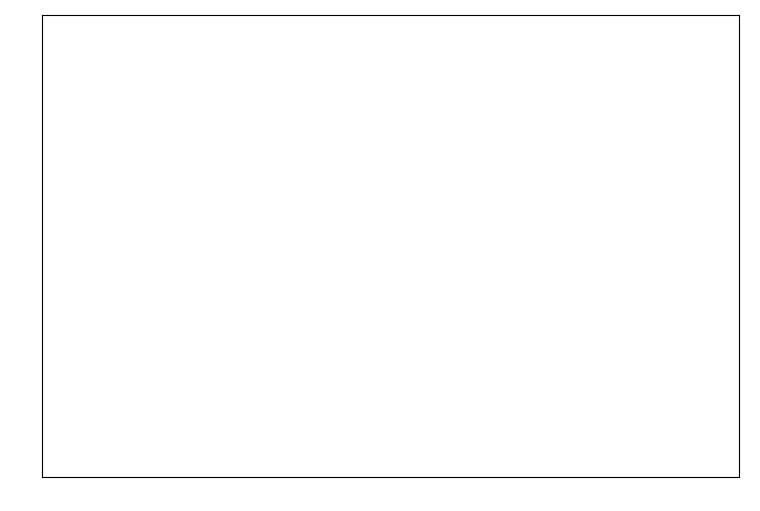

In [10]:
## High BF mean IKIs against L and R thalamus GABA
R_data = task_vs_mrs_plot(dfs['iki_metrics_bywf'], 
                               'wf_type', 
                               'high', 
                               'mean_IKI',
                               'R_thal')
print('R:', np.mean(R_data[1]), np.std(R_data[1]))

L_data = task_vs_mrs_plot(dfs['iki_metrics_bywf'], 
                               'wf_type', 
                               'high', 
                               'mean_IKI',
                               'L_thal')

print('L:', np.mean(L_data[1]), np.std(L_data[1]))

plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')

plt.scatter(R_data[1], R_data[0], s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(L_data[1], L_data[0], s = 70, 
                color = 'blue',
                label = 'Left')

plt.xlabel("R and L Thalamus GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("Mean IKI - High BF (ms)", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
# plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

plt.legend(fontsize = 17, loc="lower right")

fig.tight_layout()
# fig, ax = plt.subplots(facecolor = 'aliceblue')
plt.savefig(save_dir + 'RLthal_allbfsd.png', dpi=300)
plt.show()

In [ ]:
## High BF SD IKIs against L and R thalamus GABA
R_data = task_vs_mrs_plot(dfs['iki_metrics_bywf'], 
                               'wf_type', 
                               'high', 
                               'sd_IKI',
                               'R_thal')

L_data = task_vs_mrs_plot(dfs['iki_metrics_bywf'], 
                               'wf_type', 
                               'high', 
                               'sd_IKI',
                               'L_thal')

plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')

plt.scatter(R_data[1], R_data[0], s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(L_data[1], L_data[0], s = 70, 
                color = 'blue',
                label = 'Left')

plt.xlabel("R and L Thalamus GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("SD IKI - High BF (ms)", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(20, 120)
# plt.xlim(0.085, 0.135)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

plt.legend(fontsize = 17, loc="lower right")

fig.tight_layout()
# fig, ax = plt.subplots(facecolor = 'aliceblue')
plt.savefig(save_dir + 'RLthal_sd_highbf.png', dpi=300)
plt.show()

In [ ]:
## High BF SD IKIs against L and R thalamus GABA
R_data = task_vs_mrs_plot(dfs['iki_metrics_bywf'], 
                               'wf_type', 
                               'high', 
                               'cv_IKI',
                               'R_thal')

L_data = task_vs_mrs_plot(dfs['iki_metrics_bywf'], 
                               'wf_type', 
                               'high', 
                               'cv_IKI',
                               'L_thal')

plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')

plt.scatter(R_data[1], R_data[0], s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(L_data[1], L_data[0], s = 70, 
                color = 'blue',
                label = 'Left')

plt.xlabel("R and L Thalamus GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("Mean IKI (all Bigram Freqs.)", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
# plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

plt.legend(fontsize = 17, loc="lower right")

fig.tight_layout()
# fig, ax = plt.subplots(facecolor = 'aliceblue')
plt.savefig(save_dir + 'RLthal_allbfsd.png', dpi=300)
plt.show()

# M1 Correlations

In [11]:
# Bigram freq. task metrics vs. R and L M1 GABA/Cr

pearson_corr(dfs['iki_metrics_bybf'], 
                           'bf_type', 
                           'high', 
                           'mean_IKI',
                           'R_M1')

pearson_corr(dfs['iki_metrics_bybf'], 
                           'bf_type', 
                           'high', 
                           'mean_IKI',
                           'L_M1')

pearson_corr(dfs['iki_metrics_bybf'], 
                           'bf_type', 
                           'high', 
                           'sd_IKI',
                           'R_M1')

pearson_corr(dfs['iki_metrics_bybf'], 
                           'bf_type', 
                           'high', 
                           'sd_IKI',
                           'L_M1')

pearson_corr(dfs['iki_metrics_bybf'], 
                           'bf_type', 
                           'high', 
                           'cv_IKI',
                           'R_M1')

pearson_corr(dfs['iki_metrics_bybf'], 
                           'bf_type', 
                           'high', 
                           'cv_IKI',
                           'L_M1')

pearson_corr(dfs['delta_ikis_bybf'], 
                           'bf_type', 
                           'high', 
                           'mean_deltaiki',
                           'R_M1')

pearson_corr(dfs['delta_ikis_bybf'], 
                           'bf_type', 
                           'high', 
                           'mean_deltaiki',
                           'L_M1')

delta_var_corr(dfs['delta_vars_bybf'], 'R_M1', 'sd_diff')
delta_var_corr(dfs['delta_vars_bybf'], 'L_M1', 'sd_diff')

delta_var_corr(dfs['delta_vars_bybf'], 'R_M1', 'cv_diff')
delta_var_corr(dfs['delta_vars_bybf'], 'L_M1', 'cv_diff')

mean_IKI bf_type high vs. R_M1 GABA
PearsonRResult(statistic=np.float64(-0.19982008558922068), pvalue=np.float64(0.38516086171643193))
mean_IKI bf_type high vs. L_M1 GABA
PearsonRResult(statistic=np.float64(-0.18505248169770117), pvalue=np.float64(0.42193880822505525))
sd_IKI bf_type high vs. R_M1 GABA
PearsonRResult(statistic=np.float64(-0.12125048337465828), pvalue=np.float64(0.6005885008461064))
sd_IKI bf_type high vs. L_M1 GABA
PearsonRResult(statistic=np.float64(0.16769616904810894), pvalue=np.float64(0.46747471503976173))
cv_IKI bf_type high vs. R_M1 GABA
PearsonRResult(statistic=np.float64(-0.05548031959653053), pvalue=np.float64(0.8112155563643147))
cv_IKI bf_type high vs. L_M1 GABA
PearsonRResult(statistic=np.float64(0.39037731408565896), pvalue=np.float64(0.0801903148390371))
mean_deltaiki bf_type high vs. R_M1 GABA
PearsonRResult(statistic=np.float64(0.190070900459966), pvalue=np.float64(0.4092341138837158))
mean_deltaiki bf_type high vs. L_M1 GABA
PearsonRResult(statistic=n

In [12]:
# Word freq. task metrics vs. R and L M1 GABA/Cr

pearson_corr(dfs['iki_metrics_bywf'], 
                           'wf_type', 
                           'high', 
                           'mean_IKI',
                           'R_M1')

pearson_corr(dfs['iki_metrics_bywf'], 
                           'wf_type', 
                           'high', 
                           'mean_IKI',
                           'L_M1')

pearson_corr(dfs['iki_metrics_bywf'], 
                           'wf_type', 
                           'high', 
                           'sd_IKI',
                           'R_M1')

pearson_corr(dfs['iki_metrics_bywf'], 
                           'wf_type', 
                           'high', 
                           'sd_IKI',
                           'L_M1')

pearson_corr(dfs['iki_metrics_bywf'], 
                           'wf_type', 
                           'high', 
                           'cv_IKI',
                           'R_M1')

pearson_corr(dfs['iki_metrics_bywf'], 
                           'wf_type', 
                           'high', 
                           'cv_IKI',
                           'L_M1')

pearson_corr(dfs['delta_ikis_bywf'], 
                           'wf_type', 
                           'high', 
                           'mean_deltaiki',
                           'R_M1')

pearson_corr(dfs['delta_ikis_bywf'], 
                           'wf_type', 
                           'high', 
                           'mean_deltaiki',
                           'L_M1')

delta_var_corr(dfs['delta_vars_bywf'], 'R_M1', 'sd_diff')
delta_var_corr(dfs['delta_vars_bywf'], 'L_M1', 'sd_diff')

delta_var_corr(dfs['delta_vars_bywf'], 'R_M1', 'cv_diff')
delta_var_corr(dfs['delta_vars_bywf'], 'L_M1', 'cv_diff')

mean_IKI wf_type high vs. R_M1 GABA
PearsonRResult(statistic=np.float64(-0.05909722240117416), pvalue=np.float64(0.7991429055311933))
mean_IKI wf_type high vs. L_M1 GABA
PearsonRResult(statistic=np.float64(-0.1664431659279558), pvalue=np.float64(0.470855778849783))
sd_IKI wf_type high vs. R_M1 GABA
PearsonRResult(statistic=np.float64(0.2951224140544502), pvalue=np.float64(0.19402472926647188))
sd_IKI wf_type high vs. L_M1 GABA
PearsonRResult(statistic=np.float64(0.10245644469929545), pvalue=np.float64(0.6585393250557552))
cv_IKI wf_type high vs. R_M1 GABA
PearsonRResult(statistic=np.float64(0.5044642554578308), pvalue=np.float64(0.01969617404910098))
cv_IKI wf_type high vs. L_M1 GABA
PearsonRResult(statistic=np.float64(0.2716075828100025), pvalue=np.float64(0.23365380197531782))
mean_deltaiki wf_type high vs. R_M1 GABA
PearsonRResult(statistic=np.float64(-0.1345871181330341), pvalue=np.float64(0.5608048110089738))
mean_deltaiki wf_type high vs. L_M1 GABA
PearsonRResult(statistic=np.flo

### M1 figures

R: 0.11540822447619048 0.006487439829834443
L: 0.11154643633333333 0.005811842738256015
21


TypeError: unhashable type: 'numpy.ndarray'

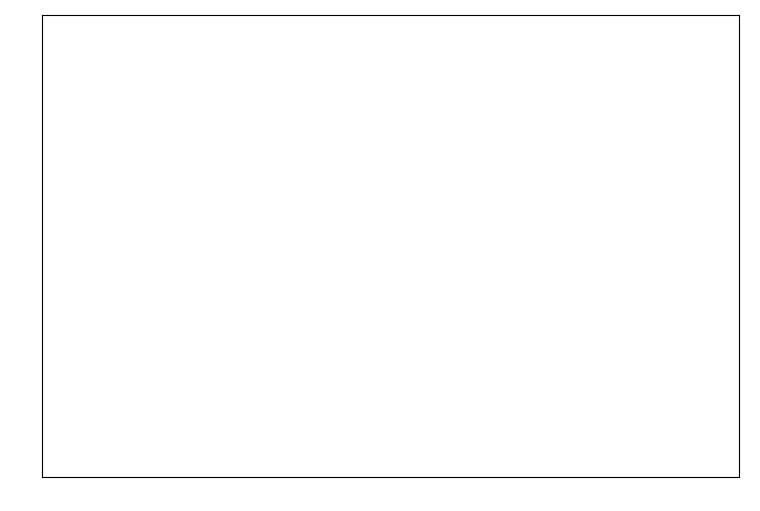

In [13]:
## High BF mean IKIs against L and R M1 GABA
R_data = task_vs_mrs_plot(dfs['iki_metrics_bywf'], 
                               'wf_type', 
                               'high', 
                               'mean_IKI',
                               'R_M1')

L_data = task_vs_mrs_plot(dfs['iki_metrics_bywf'], 
                               'wf_type', 
                               'high', 
                               'mean_IKI',
                               'L_M1')

print('R:', np.mean(R_data[1]), np.std(R_data[1]))
print('L:', np.mean(L_data[1]), np.std(L_data[1]))
print(len(R_data[0]))

plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')

plt.scatter(R_data[1], R_data[0], s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(L_data[1], L_data[0], s = 70, 
                color = 'blue',
                label = 'Left')

plt.xlabel("R and L M1 GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("Mean IKI - High BF (ms)", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
# plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

plt.legend(fontsize = 17, loc="lower right")

fig.tight_layout()
# fig, ax = plt.subplots(facecolor = 'aliceblue')
plt.savefig(save_dir + 'RLthal_allbfsd.png', dpi=300)
plt.show()

In [ ]:
## High BF SD IKIs against L and R M1 GABA
R_data = task_vs_mrs_plot(dfs['iki_metrics_bywf'], 
                               'wf_type', 
                               'high', 
                               'sd_IKI',
                               'R_M1')

L_data = task_vs_mrs_plot(dfs['iki_metrics_bywf'], 
                               'wf_type', 
                               'high', 
                               'sd_IKI',
                               'L_M1')

plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')

plt.scatter(R_data[1], R_data[0], s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(L_data[1], L_data[0], s = 70, 
                color = 'blue',
                label = 'Left')

plt.xlabel("R and L M1 GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("SD IKI - High BF (ms)", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(20, 120)
# plt.xlim(0.085, 0.135)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

plt.legend(fontsize = 17, loc="lower right")

fig.tight_layout()
# fig, ax = plt.subplots(facecolor = 'aliceblue')
plt.savefig(save_dir + 'RLthal_sd_highbf.png', dpi=300)
plt.show()

In [ ]:
## High BF CV IKIs against L and R M1 GABA
R_data = task_vs_mrs_plot(dfs['iki_metrics_bywf'], 
                               'wf_type', 
                               'high', 
                               'cv_IKI',
                               'R_M1')

L_data = task_vs_mrs_plot(dfs['iki_metrics_bywf'], 
                               'wf_type', 
                               'high', 
                               'cv_IKI',
                               'L_M1')

plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')

plt.scatter(R_data[1], R_data[0], s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(L_data[1], L_data[0], s = 70, 
                color = 'blue',
                label = 'Left')

plt.xlabel("R and L M1 GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("CV IKI - High BF (ms)", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
# plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

plt.legend(fontsize = 17, loc="lower right")

fig.tight_layout()
# fig, ax = plt.subplots(facecolor = 'aliceblue')
plt.savefig(save_dir + 'RLthal_allbfsd.png', dpi=300)
plt.show()

# Occipital Correlations

In [ ]:
occ_sIDs = GABA_quant[GABA_quant['voxel'] == 'occ'].dropna().sID.unique()
occ = GABA_quant[GABA_quant['voxel'] == 'occ']['Mean_GABA_Cr']

print('M1 v. High BF Mean IKI')
R_meaniki_bf = pearson_filter(dfs['iki_metrics_bybf'], 
                           'bf_type', 
                           'high', 
                           'mean_IKI',
                           occ_sIDs)
print(pearsonr(R_meaniki_bf, occ))

print('M1 v. High BF SD IKI')
R_sdiki_bf = pearson_filter(dfs['iki_metrics_bybf'], 
                           'bf_type', 
                           'high', 
                           'sd_IKI',
                           occ_sIDs)
print(pearsonr(R_sdiki_bf, occ))

print('GABA v. High BF CV IKI')
R_cviki_bf = pearson_filter(dfs['iki_metrics_bybf'], 
                           'bf_type', 
                           'high', 
                           'cv_IKI',
                           occ_sIDs)
print(pearsonr(R_cviki_bf, occ))

print('GABA v. High BF Delta IKI')
R_deltaiki_bf = pearson_filter(dfs['delta_ikis_bybf'], 
                           'bf_type', 
                           'high', 
                           'mean_deltaiki',
                           occ_sIDs)
print(pearsonr(R_deltaiki_bf, occ))

In [ ]:
# Bigram freq. task metrics vs. Occipital GABA/Cr

pearson_corr(dfs['iki_metrics_bybf'], 
                           'bf_type', 
                           'high', 
                           'mean_IKI',
                           'occ')

pearson_corr(dfs['iki_metrics_bybf'], 
                           'bf_type', 
                           'high', 
                           'sd_IKI',
                           'occ')

pearson_corr(dfs['iki_metrics_bybf'], 
                           'bf_type', 
                           'high', 
                           'cv_IKI',
                           'occ')

pearson_corr(dfs['delta_ikis_bybf'], 
                           'bf_type', 
                           'high', 
                           'mean_deltaiki',
                           'occ')

delta_var_corr(dfs['delta_vars_bybf'], 'occ', 'sd_diff')

delta_var_corr(dfs['delta_vars_bybf'], 'occ', 'cv_diff')

In [ ]:
# Word freq. task metrics vs. R and L Thalamic GABA/Cr

pearson_corr(dfs['iki_metrics_bywf'], 
                           'wf_type', 
                           'high', 
                           'mean_IKI',
                           'occ')

pearson_corr(dfs['iki_metrics_bywf'], 
                           'wf_type', 
                           'high', 
                           'sd_IKI',
                           'occ')

pearson_corr(dfs['iki_metrics_bywf'], 
                           'wf_type', 
                           'high', 
                           'cv_IKI',
                           'occ')

pearson_corr(dfs['delta_ikis_bywf'], 
                           'wf_type', 
                           'high', 
                           'mean_deltaiki',
                           'occ')

delta_var_corr(dfs['delta_vars_bywf'], 'occ', 'sd_diff')

delta_var_corr(dfs['delta_vars_bywf'], 'occ', 'cv_diff')